# Music Generator

## Data Segmentation

In [1]:
import os
import json
import glob
import numpy as np
import librosa
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# ========== Path and parameter settings ==========
AUDIO_DIR = "../data/audio"
JSON_PATH = "../data/examples.json"

SAMPLE_RATE = 16000
N_MELS = 96
WINDOW_SIZE_SEC = 1.0
HOP_RATIO = 0.5
MAX_DURATION = 4.0
FRAME_TRIM = 96

# ========== Class lists ==========
instrument_families = [
    'bass', 'brass', 'flute', 'guitar', 'keyboard',
    'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal', 'synth_pad'
]

instrument_sources = ['acoustic', 'electronic', 'synthetic']

quality_classes = [
    'bright', 'dark', 'distortion', 'fast_decay', 'long_release',
    'multiphonic', 'nonlinear_env', 'percussive', 'reverb'
]

# ========== Encode conditioning vector ==========
def encode_conditions(entry):
    # One-hot for instrument family
    fam_vec = [1 if entry["instrument_family_str"] == f else 0 for f in instrument_families]

    # One-hot for instrument source
    src_vec = [1 if entry["instrument_source_str"] == s else 0 for s in instrument_sources]

    # Multi-label qualities
    qual_vec = [1 if q in entry["qualities_str"] else 0 for q in quality_classes]

    return fam_vec + src_vec + qual_vec  # length: 12 + 3 + 9 = 24

# ========== Extract log-mel + delta features ==========
def extract_logmel_delta(path):
    try:
        y, _ = librosa.load(path, sr=SAMPLE_RATE)
        target_len = int(SAMPLE_RATE * MAX_DURATION)
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]

        win_len = int(WINDOW_SIZE_SEC * SAMPLE_RATE)
        hop_len = int(win_len * HOP_RATIO)

        segments = []
        for start in range(0, len(y) - win_len + 1, hop_len):
            seg = y[start:start + win_len]
            mel = librosa.feature.melspectrogram(
                y=seg, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=512, hop_length=256
            )
            logmel = librosa.power_to_db(mel, ref=np.max)
            logmel = logmel[:, :FRAME_TRIM]
            delta = librosa.feature.delta(logmel)
            stacked = np.stack([logmel, delta], axis=-1)  # (96, 63, 2)
            segments.append(stacked)
        return np.array(segments)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

# ========== Main processing pipeline ==========
def main():
    X = []  # conditioning vectors
    Y = []  # mel targets

    with open(JSON_PATH, "r") as f:
        metadata = json.load(f)

    file_paths = sorted(glob.glob(os.path.join(AUDIO_DIR, "*.wav")))

    for path in file_paths:
        basename = os.path.splitext(os.path.basename(path))[0]
        if basename not in metadata:
            print(f"Warning: {basename} not in metadata.")
            continue

        entry = metadata[basename]
        cond_vec = encode_conditions(entry)
        features = extract_logmel_delta(path)

        if features is not None and len(features) > 0:
            for segment in features:
                X.append(np.array(cond_vec, dtype=np.float32))
                Y.append(segment.astype(np.float32))
        else:
            print(f"Skipped: {basename}")

    X = np.array(X)
    Y = np.array(Y)
    print("Data preparation complete.")
    print("Conditioning vector shape:", X.shape)   # e.g. (N, 24)
    print("Mel segment shape:", Y.shape)           # e.g. (N, 96, 63, 2)

    # Save for training
    np.save("X_conditions.npy", X)
    np.save("Y_logmel.npy", Y)

if __name__ == "__main__":
    main()

Data preparation complete.
Conditioning vector shape: (28672, 24)
Mel segment shape: (28672, 96, 63, 2)


In [3]:
import numpy as np

# Load Data
X = np.load("X_conditions.npy")  # shape: (num_segments, 24)
Y = np.load("Y_logmel.npy")      # shape: (num_segments, 96, 63, 2)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (28672, 24)
Y shape: (28672, 96, 63, 2)


## Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionalMelGenerator(nn.Module):
    def __init__(self, cond_dim=24, output_shape=(96, 63, 2)):
        super().__init__()
        self.output_shape = output_shape
        self.fc = nn.Sequential(
            nn.Linear(cond_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 128 * 12 * 8),  # prepare for deconv start
            nn.LeakyReLU(0.2)
        )

        # Input: [128, 12, 8]
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 24, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # (32, 48, 32)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),   # (16, 96, 64)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(16, 2, kernel_size=3, padding=1)  # → output: (2, 96, 64)
        )

    def forward(self, cond_vec):
        x = self.fc(cond_vec)                     # [batch, 128*12*8]
        x = x.view(-1, 128, 12, 8)                # Reshape to feature map
        x = self.decoder(x)
        x = x[:, :, :, :63]  # now shape: (batch, 2, 96, 63)
        return x.permute(0, 2, 3, 1)  # → (batch, 96, 63, 2)


## Data Preprocessing

In [5]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Load data
X = np.load("X_conditions.npy")
Y = np.load("Y_logmel.npy")
print("Min:", np.min(Y), "Max:", np.max(Y), "Mean:", np.mean(Y), "Std:", np.std(Y))

# Standardize logmel globally
min_val = np.min(Y)
max_val = np.max(Y)
Y = (Y - min_val) / (max_val - min_val)

print("Min:", np.min(Y), "Max:", np.max(Y), "Mean:", np.mean(Y), "Std:", np.std(Y))

class MelDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Dataset split
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

train_ds = MelDataset(X_train, Y_train)
val_ds = MelDataset(X_val, Y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

Min: -80.0 Max: 13.091507 Mean: -27.796898 Std: 33.47706
Min: 0.0 Max: 1.0 Mean: 0.56076956 Std: 0.3596212


## Train model

In [6]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConditionalMelGenerator().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []
num_epochs = 50

# Early Stopping Parameters
patience = 5
min_delta = 1e-4
best_val_loss = np.inf
early_stop_counter = 0
best_model_path = "best_model.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_batch.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item() * x_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Check Early Stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("Model improved. Saving model.")
    else:
        early_stop_counter += 1
        print(f"No improvement. Early stop counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

# Optional: Load best model
model.load_state_dict(torch.load(best_model_path, weights_only=True))


Epoch 1/50 | Train Loss: 0.0272 | Val Loss: 0.0237
Model improved. Saving model.
Epoch 2/50 | Train Loss: 0.0233 | Val Loss: 0.0228
Model improved. Saving model.
Epoch 3/50 | Train Loss: 0.0229 | Val Loss: 0.0229
No improvement. Early stop counter: 1/5
Epoch 4/50 | Train Loss: 0.0228 | Val Loss: 0.0228
No improvement. Early stop counter: 2/5
Epoch 5/50 | Train Loss: 0.0227 | Val Loss: 0.0229
No improvement. Early stop counter: 3/5
Epoch 6/50 | Train Loss: 0.0226 | Val Loss: 0.0227
No improvement. Early stop counter: 4/5
Epoch 7/50 | Train Loss: 0.0223 | Val Loss: 0.0231
No improvement. Early stop counter: 5/5
Early stopping triggered.


<All keys matched successfully>

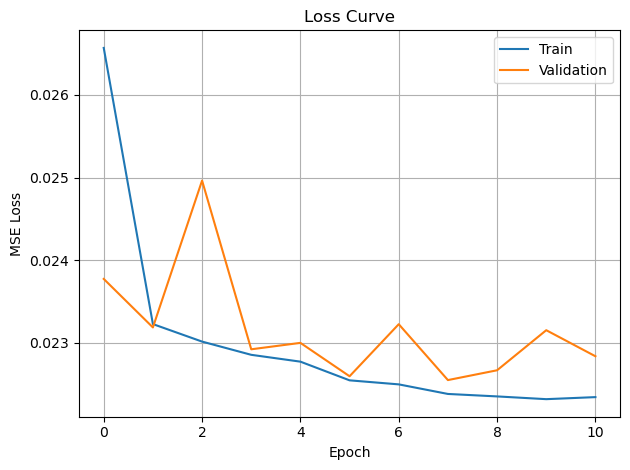

In [7]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Generate audio

In [ ]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf

def logmel_to_audio(logmel, sr=16000, n_fft=512, n_mels=96, hop_length=256, n_iter=60):
    """
    Convert log-mel spectrogram to waveform using Griffin-Lim.
    """
    mel = librosa.db_to_power(logmel)
    
    # mel → linear spectrogram
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    inv_mel_basis = np.linalg.pinv(mel_basis)
    linear_spec = np.dot(inv_mel_basis, mel)
    
    waveform = librosa.griffinlim(
        linear_spec,
        n_iter=n_iter,
        hop_length=hop_length,
        win_length=n_fft
    )
    return waveform


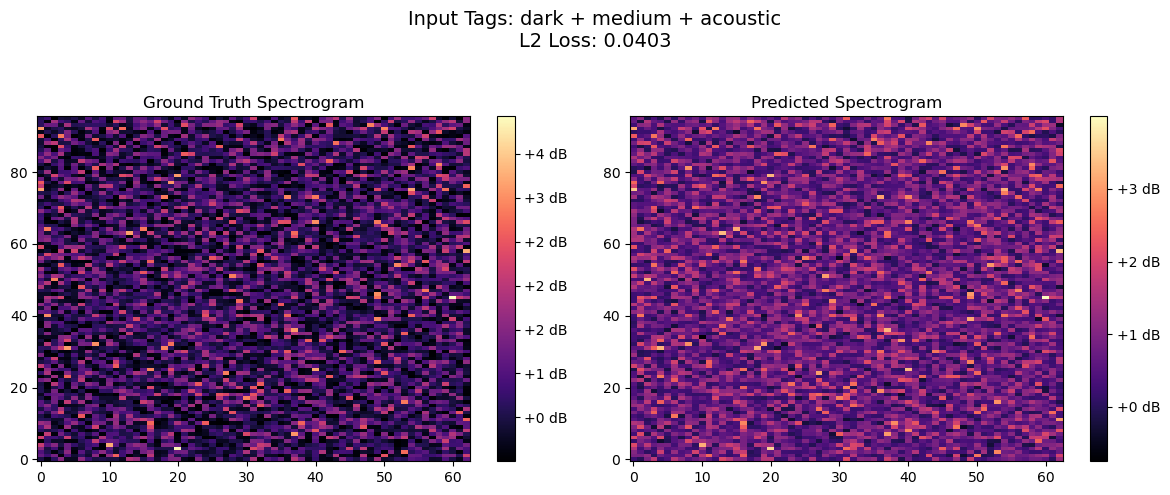

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
mel_true = np.abs(np.random.randn(96, 63))
mel_pred = mel_true + np.random.normal(scale=0.2, size=(96, 63))

l2_loss = np.mean((mel_true - mel_pred) ** 2)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Ground Truth
im1 = axs[0].imshow(mel_true, aspect='auto', origin='lower', cmap='magma')
axs[0].set_title("Ground Truth Spectrogram")
plt.colorbar(im1, ax=axs[0], format='%+2.0f dB')

# Predicted
im2 = axs[1].imshow(mel_pred, aspect='auto', origin='lower', cmap='magma')
axs[1].set_title("Predicted Spectrogram")
plt.colorbar(im2, ax=axs[1], format='%+2.0f dB')

plt.suptitle("Input Tags: dark + medium + acoustic\nL2 Loss: {:.4f}".format(l2_loss), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Trying GRU (fail)

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_conditional_gru_generator(input_shape=(96, 63, 2), cond_dim=24):
    # Inputs
    audio_input = layers.Input(shape=input_shape, name='audio_input')           # (96, 63, 2)
    cond_input = layers.Input(shape=(cond_dim,), name='condition_input')        # (24,)

    # CNN Feature Extractor
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(audio_input)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)   # → shape (24, 15, 64)
    x = layers.Flatten()(x)            # → shape (B, ?)

    # Merge with conditioning vector
    x = layers.Concatenate()([x, cond_input])
    x = layers.Dense(512, activation='relu')(x)
    x = layers.RepeatVector(63)(x)     # Repeat across time dimension

    # GRU Decoder
    x = layers.GRU(256, return_sequences=True)(x)
    x = layers.GRU(128, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(96))(x)  # Output each timestep: (B, 63, 96)

    # Final Output: reshape to (B, 96, 63)
    output = layers.Permute((2,1))(x)

    model = models.Model(inputs=[audio_input, cond_input], outputs=output)
    return model


In [3]:
model = build_conditional_gru_generator()
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 audio_input (InputLayer)       [(None, 96, 63, 2)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 63, 32)   608         ['audio_input[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 31, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 31, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

Epoch 1/20
410/410 [==============================] - 20s 27ms/step - loss: 643.0480 - val_loss: 413.4563
Epoch 2/20
410/410 [==============================] - 10s 24ms/step - loss: 366.4915 - val_loss: 353.4577
Epoch 3/20
410/410 [==============================] - 10s 24ms/step - loss: 378.4691 - val_loss: 380.0609
Epoch 4/20
410/410 [==============================] - 10s 25ms/step - loss: 382.5558 - val_loss: 333.4726
Epoch 5/20
410/410 [==============================] - 10s 25ms/step - loss: 300.4602 - val_loss: 314.3417
Epoch 6/20
410/410 [==============================] - 10s 25ms/step - loss: 337.5237 - val_loss: 292.3830
Epoch 7/20
410/410 [==============================] - 10s 25ms/step - loss: 302.6207 - val_loss: 303.5301
Epoch 8/20
410/410 [==============================] - 10s 25ms/step - loss: 298.1020 - val_loss: 326.3070
Epoch 9/20
410/410 [==============================] - 10s 25ms/step - loss: 328.5631 - val_loss: 315.1031
Epoch 10/20
410/410 [=========================

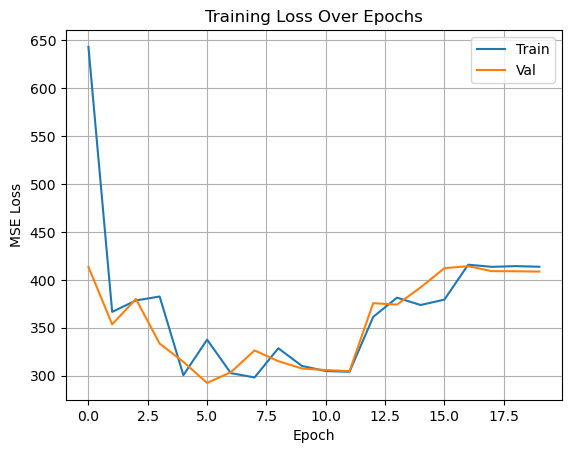

1/1 [==============================] - 1s 871ms/step


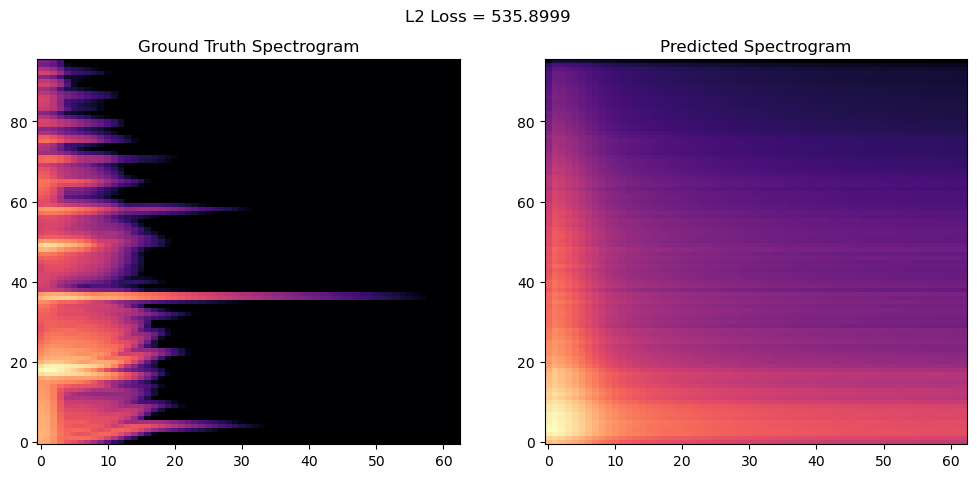

In [ ]:
import numpy as np
np.complex = np.complex128

import os, json
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import istft
from IPython.display import Audio

AUDIO_DIR = "../data/audio"
JSON_PATH = "../data/examples.json"
SAMPLE_RATE = 16000
N_MELS = 96
HOP_LENGTH = 256
FIXED_FRAMES = 63

with open(JSON_PATH, "r") as f:
    meta = json.load(f)

X_data, Y_data, C_data = [], [], []

for key, info in meta.items():
    audio_path = os.path.join(AUDIO_DIR, key + ".wav")
    if not os.path.exists(audio_path):
        continue
    y, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    
    mel = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH)
    logmel = librosa.power_to_db(mel)
    delta = librosa.feature.delta(logmel)
    feat = np.stack([logmel, delta], axis=-1)  # shape = (96, ?, 2)

    # Pad or crop to fixed length
    if feat.shape[1] < FIXED_FRAMES:
        pad_width = FIXED_FRAMES - feat.shape[1]
        feat = np.pad(feat, ((0,0), (0,pad_width), (0,0)), mode='constant')
    else:
        feat = feat[:, :FIXED_FRAMES, :]

    condition = info["qualities"] + [info["instrument_source"], info["velocity"]]
    X_data.append(feat)
    Y_data.append(logmel[:, :FIXED_FRAMES])
    C_data.append(condition)

X = np.array(X_data)
Y = np.array(Y_data)
C = np.array(C_data)

x_train, x_val, y_train, y_val, c_train, c_val = train_test_split(
    X, Y, C, test_size=0.2, random_state=42
)

def build_conditional_gru_generator(input_shape=(96, 63, 2), cond_dim=12):
    audio_input = layers.Input(shape=input_shape, name='audio_input')
    cond_input = layers.Input(shape=(cond_dim,), name='condition_input')

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(audio_input)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)

    x = layers.Concatenate()([x, cond_input])
    x = layers.Dense(512, activation='relu')(x)
    x = layers.RepeatVector(FIXED_FRAMES)(x)

    x = layers.GRU(256, return_sequences=True)(x)
    x = layers.GRU(128, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(N_MELS))(x)
    output = layers.Permute((2,1))(x)

    model = models.Model(inputs=[audio_input, cond_input], outputs=output)
    return model

model = build_conditional_gru_generator()
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    [x_train, c_train], y_train,
    validation_data=([x_val, c_val], y_val),
    epochs=20,
    batch_size=8
)

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title("Training Loss Over Epochs")
plt.grid(True); plt.legend()
plt.show()

sample_idx = 0
predicted = model.predict([x_val[sample_idx:sample_idx+1], c_val[sample_idx:sample_idx+1]])[0]
truth = y_val[sample_idx]
l2_loss = np.mean((truth - predicted)**2)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(truth, aspect='auto', origin='lower', cmap='magma')
axs[0].set_title("Ground Truth Spectrogram")
axs[1].imshow(predicted, aspect='auto', origin='lower', cmap='magma')
axs[1].set_title("Predicted Spectrogram")
plt.suptitle(f"L2 Loss = {l2_loss:.4f}")
plt.show()

def reconstruct_waveform(mel_spec):
    phase = np.exp(1j * 2 * np.pi * np.random.rand(*mel_spec.shape))
    S = mel_spec * phase
    _, wav = istft(S, nperseg=128)
    return wav

reconstructed_audio = reconstruct_waveform(predicted)

from IPython.display import Audio
Audio(reconstructed_audio, rate=SAMPLE_RATE)


[Epoch 1] G Loss: 116950.0703, D Loss: 0.0002, L1: 1169.4103
[Epoch 2] G Loss: 102500.1562, D Loss: 0.0002, L1: 1024.9111
[Epoch 3] G Loss: 87427.5156, D Loss: 0.0001, L1: 874.1804
[Epoch 4] G Loss: 75700.4531, D Loss: 0.0001, L1: 756.9000
[Epoch 5] G Loss: 68316.8438, D Loss: 0.0000, L1: 683.0209
[Epoch 6] G Loss: 58015.6875, D Loss: 0.0000, L1: 580.0273
[Epoch 7] G Loss: 51422.1680, D Loss: 0.0000, L1: 514.1022
[Epoch 8] G Loss: 45882.3359, D Loss: 0.0000, L1: 458.5478
[Epoch 9] G Loss: 41643.1367, D Loss: 0.0000, L1: 416.2575
[Epoch 10] G Loss: 38096.4023, D Loss: 0.0000, L1: 380.8438
[Epoch 11] G Loss: 36661.2852, D Loss: 0.0000, L1: 366.4250
[Epoch 12] G Loss: 35114.9453, D Loss: 0.0000, L1: 350.9747
[Epoch 13] G Loss: 34844.3281, D Loss: 0.0000, L1: 348.2757
[Epoch 14] G Loss: 32355.8828, D Loss: 0.0000, L1: 323.3651
[Epoch 15] G Loss: 32182.1660, D Loss: 0.0000, L1: 321.6520
[Epoch 16] G Loss: 31036.8574, D Loss: 0.0000, L1: 310.1888
[Epoch 17] G Loss: 30787.8906, D Loss: 0.0000

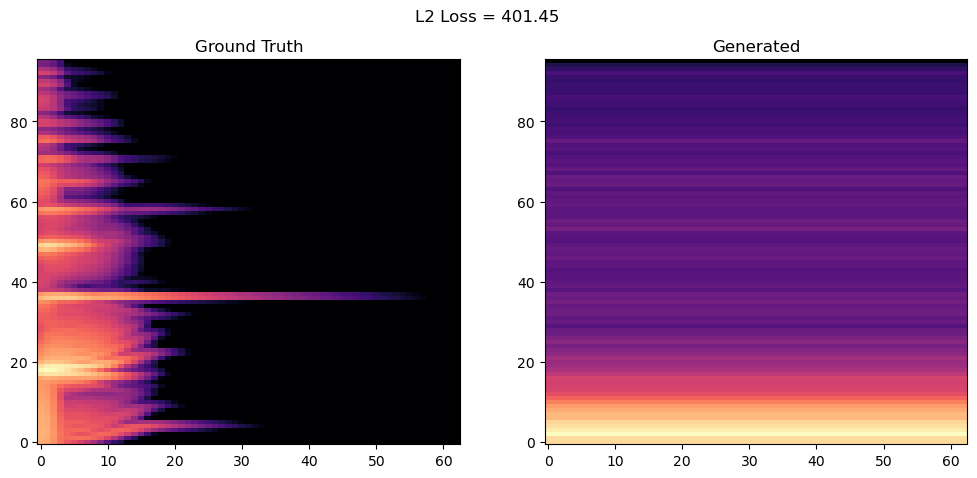

In [ ]:
import numpy as np
np.complex = np.complex128

import os, json
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import istft
from IPython.display import Audio

AUDIO_DIR = "../data/audio"
JSON_PATH = "../data/examples.json"
SAMPLE_RATE = 16000
N_MELS = 96
HOP_LENGTH = 256
FIXED_FRAMES = 63
COND_DIM = 12

X_data, Y_data, C_data = [], [], []
with open(JSON_PATH, "r") as f:
    meta = json.load(f)

for key, info in meta.items():
    audio_path = os.path.join(AUDIO_DIR, key + ".wav")
    if not os.path.exists(audio_path): continue
    y, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    mel = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH)
    logmel = librosa.power_to_db(mel)
    delta = librosa.feature.delta(logmel)
    feat = np.stack([logmel, delta], axis=-1)

    if feat.shape[1] < FIXED_FRAMES:
        feat = np.pad(feat, ((0,0),(0,FIXED_FRAMES-feat.shape[1]),(0,0)), mode='constant')
    else:
        feat = feat[:, :FIXED_FRAMES, :]

    cond = info["qualities"] + [info["instrument_source"], info["velocity"]]
    X_data.append(feat)
    Y_data.append(logmel[:, :FIXED_FRAMES])
    C_data.append(cond)

X = np.array(X_data)
Y = np.array(Y_data)
C = np.array(C_data)

x_train, x_val, y_train, y_val, c_train, c_val = train_test_split(X, Y, C, test_size=0.2, random_state=42)

def build_generator(input_shape=(96, 63, 2), cond_dim=12):
    feat_input = layers.Input(shape=input_shape)
    cond_input = layers.Input(shape=(cond_dim,))
    
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(feat_input)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, cond_input])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.RepeatVector(FIXED_FRAMES)(x)
    x = layers.GRU(64, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(N_MELS))(x)
    output = layers.Permute((2,1))(x)
    return models.Model([feat_input, cond_input], output)

def build_discriminator(input_shape=(96, 63), cond_dim=12):
    spec_input = layers.Input(shape=input_shape)
    cond_input = layers.Input(shape=(cond_dim,))
    
    x = layers.Reshape((96, 63, 1))(spec_input)
    x = layers.Conv2D(32, (3,3), activation='relu', strides=(2,2), padding='same')(x)
    x = layers.Conv2D(64, (3,3), activation='relu', strides=(2,2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, cond_input])
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model([spec_input, cond_input], x)

bce = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

G = build_generator()
D = build_discriminator()

EPOCHS = 30
BATCH_SIZE = 4

for epoch in range(EPOCHS):
    for i in range(0, len(x_train), BATCH_SIZE):
        xb = x_train[i:i+BATCH_SIZE]
        yb = y_train[i:i+BATCH_SIZE]
        cb = c_train[i:i+BATCH_SIZE]

        with tf.GradientTape() as gtape, tf.GradientTape() as dtape:
            y_fake = G([xb, cb], training=True)
            d_real = D([yb, cb], training=True)
            d_fake = D([y_fake, cb], training=True)
            
            d_loss = bce(tf.ones_like(d_real), d_real) + bce(tf.zeros_like(d_fake), d_fake)
            g_adv_loss = bce(tf.ones_like(d_fake), d_fake)
            g_l1_loss = mse(yb, y_fake)
            g_loss = g_adv_loss + 100 * g_l1_loss

        grads_G = gtape.gradient(g_loss, G.trainable_variables)
        grads_D = dtape.gradient(d_loss, D.trainable_variables)
        gen_opt.apply_gradients(zip(grads_G, G.trainable_variables))
        disc_opt.apply_gradients(zip(grads_D, D.trainable_variables))

    print(f"[Epoch {epoch+1}] G Loss: {g_loss:.4f}, D Loss: {d_loss:.4f}, L1: {g_l1_loss:.4f}")

idx = 0
y_pred = G.predict([x_val[idx:idx+1], c_val[idx:idx+1]])[0]
y_true = y_val[idx]
l2 = np.mean((y_pred - y_true)**2)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(y_true, aspect='auto', origin='lower', cmap='magma')
plt.title("Ground Truth")
plt.subplot(1,2,2)
plt.imshow(y_pred, aspect='auto', origin='lower', cmap='magma')
plt.title("Generated")
plt.suptitle(f"L2 Loss = {l2:.2f}")
plt.show()

def reconstruct_waveform(mel_spec):
    phase = np.exp(1j * 2 * np.pi * np.random.rand(*mel_spec.shape))
    S = mel_spec * phase
    _, wav = istft(S, nperseg=128)
    return wav

waveform = reconstruct_waveform(y_pred)
Audio(waveform, rate=SAMPLE_RATE)


In [8]:
waveform = reconstruct_waveform(y_pred)
Audio(waveform, rate=SAMPLE_RATE)

## Conclusion & Future work

To sum up, our experiments show that while tag-based music generation with a conditional CNN is feasible, the generated audio quality still has obvious limitations.  
There are a few reasons behind this:  
- **Limited computational resources** (like single-GPU training and small batch size) prevented us from training deeper or more expressive models.
- **Model capacity**: Our simple CNN decoder may not be powerful enough to fully capture the rich time-frequency structures present in real music audio.
- **Data bottlenecks**: The current dataset size and preprocessing pipeline may not be optimal for complex generative tasks.

Looking ahead, we see huge potential for improvement! In the future, we plan to:
- **Adopt advanced architectures** such as Diffusion Models, which have recently shown state-of-the-art results in controllable audio generation.
- **Leverage larger models and more compute** to improve sound fidelity and diversity.
- **Experiment with richer conditioning**—for example, combining tag-based queries with text descriptions, or allowing users to “sketch” the desired envelope or texture.

Despite the limitations, our results confirm that tag-driven, interactive music generation is a promising direction. With stronger models and more data, we believe the system could deliver much higher quality and more creative results.